# Домашно 1


### В това домашно задачата ви е да класифицирате всяка картинка от тестовото множество във 53-те различни класа. Накрая покажете какво е accuracy-то на вашия модел върху това тестово множество. (Accuracy = Correct/Total).

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
from google.colab import files

In [2]:
from torchvision.transforms import v2 as T
from torch import nn
from tqdm.auto import tqdm
from timeit import default_timer as timer
from torch.functional import F
from torchsummary import summary

### За да можете да заредите Kaggle dataset, трябва да се логнете в Kaggle и да изтеглите API Token от Settings -> Create New Token. Това ще свали kaggle.json файл, който трябва да качите в следващата клетка.

In [3]:
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
! kaggle datasets download -d gpiosenka/cards-image-datasetclassification
! unzip cards-image-datasetclassification.zip -d cards-image-datasetclassification

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: cards-image-datasetclassification/train/jack of spades/059.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/060.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/061.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/062.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/063.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/064.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/065.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/066.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/067.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/068.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/069.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/070.jp

In [5]:
df = pd.read_csv("/content/cards-image-datasetclassification/cards.csv")
df.head()

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train


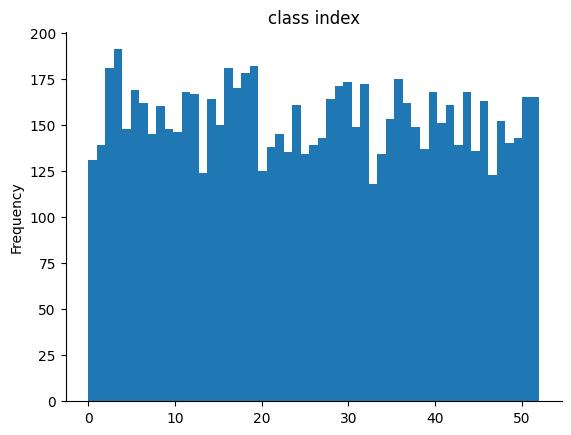

In [6]:
# @title class index

from matplotlib import pyplot as plt
df['class index'].plot(kind='hist', bins=53, title='class index')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
df[df["data set"] == "train"].shape, df[df["data set"] == "valid"].shape, df[df["data set"] == "test"].shape,

((7625, 5), (265, 5), (265, 5))

In [8]:
df["labels"].unique()

array(['ace of clubs', 'ace of diamonds', 'ace of hearts',
       'ace of spades', 'eight of clubs', 'eight of diamonds',
       'eight of hearts', 'eight of spades', 'five of clubs',
       'five of diamonds', 'five of hearts', 'five of spades',
       'four of clubs', 'four of diamonds', 'four of hearts',
       'four of spades', 'jack of clubs', 'jack of diamonds',
       'jack of hearts', 'jack of spades', 'joker', 'king of clubs',
       'king of diamonds', 'king of hearts', 'king of spades',
       'nine of clubs', 'nine of diamonds', 'nine of hearts',
       'nine of spades', 'queen of clubs', 'queen of diamonds',
       'queen of hearts', 'queen of spades', 'seven of clubs',
       'seven of diamonds', 'seven of hearts', 'seven of spades',
       'six of clubs', 'six of diamonds', 'six of hearts',
       'six of spades', 'ten of clubs', 'ten of diamonds',
       'ten of hearts', 'ten of spades', 'three of clubs',
       'three of diamonds', 'three of hearts', 'three of spades',

Metaparameters

In [51]:
batch_size = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
classifier_dropout=0.3
spatial_dropout=0.15

In [10]:
df['card type'].unique()

array(['ace', 'eight', 'five', 'four', 'jack', 'xxx', 'king', 'nine',
       'queen', 'seven', 'six', 'ten', 'three', 'two'], dtype=object)

In [11]:
transfrom = T.Compose([T.ToImage(),
                       T.ToDtype(torch.float32, scale=True),
                       T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_data = datasets.ImageFolder(root="./cards-image-datasetclassification/test", transform=transfrom)
train_data = datasets.ImageFolder(root="./cards-image-datasetclassification/train", transform=transfrom)
valid_data = datasets.ImageFolder(root="./cards-image-datasetclassification/valid", transform=transfrom)

In [12]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [13]:
X, y = next(iter(train_dataloader))

In [14]:
print('Data shapes (train/test):')
print( X.data.shape )

print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([32, 3, 224, 224])

Data value range:
(tensor(-1.), tensor(1.))


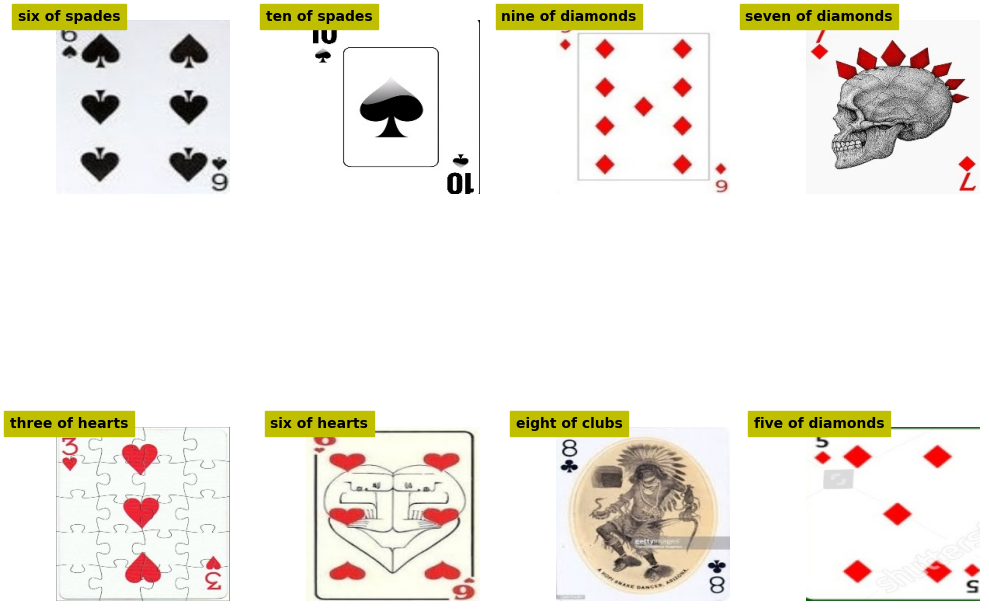

In [15]:
fig,axs = plt.subplots(2, 4,figsize=(10, 10))

for (i,ax) in enumerate(axs.flatten()):
  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = train_data.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

Train

In [16]:
def train_step(model, data_loader, loss_fn, optimizer, device):

    model.train()

    train_loss, train_acc = 0, 0

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    return train_loss / len(data_loader), train_acc / len(data_loader)


def test_step(model, data_loader, loss_fn, device):

    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    return test_loss / len(data_loader), test_acc / len(data_loader)

def train(model,
          train_data_loader,
          test_data_loader,
          optimizer,
          loss_fn,
          epochs,
          device):

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
        }

    model.to(device)

    for epoch in tqdm(range(epochs)):

        start_time = timer()
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_data_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )
        end_time = timer()

        test_loss, test_acc = test_step(
            model=model,
            data_loader=test_data_loader,
            loss_fn=loss_fn,
            device=device,
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"time: {(end_time-start_time):.4f}"
        )

    return results

def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

Model

In [17]:
class BottleneckBlock(nn.Module):
  def __init__(self, in_channels, mid_channels, out_channels, stride):
    super().__init__()
    self.use_skip = in_channels == out_channels and stride == 1
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.stride = stride

    self.block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.GELU(),

            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride,
                      padding=1, groups=mid_channels, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.GELU(),

            nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    self.shortcut = nn.Identity()
    if not self.use_skip:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(out_channels)
      )


  def forward(self, x):
    return F.gelu(self.block(x) + self.shortcut(x))

In [18]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.GELU(),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        w = self.pool(x).view(b, c)
        w = self.fc(w).view(b, c, 1, 1)
        return x * w

In [55]:
class CNN(nn.Module):
  def __init__(self, input_size, output_size, spatial_dropout, classifier_dropout):
      super().__init__()
      self.input_size = input_size
      self.output_size = output_size
      self.spatial_dropout = nn.Dropout2d(spatial_dropout)
      self.classifier_dropout = nn.Dropout2d(classifier_dropout)
      self.start = nn.Sequential(
          nn.Conv2d(input_size, 64, kernel_size=3, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(64),
          nn.GELU())

      def make_stage(in_c, mid_c, out_c, stride, num_blocks):
        layers = [BottleneckBlock(in_c, mid_c, out_c, stride=stride), SEBlock(out_c)]
        for _ in range(1, num_blocks):
            layers.append(BottleneckBlock(out_c, mid_c, out_c, stride=1))
            layers.append(SEBlock(out_c))
        return nn.Sequential(*layers)

      self.stage1 = make_stage(64, 64, 128, stride=1, num_blocks=2)
      self.stage2 = make_stage(128, 128, 256, stride=2, num_blocks=2)
      self.stage3 = make_stage(256, 256, 512, stride=2, num_blocks=3)
      self.stage4 = make_stage(512, 256, 1024, stride=2, num_blocks=3)
      self.stage5 = make_stage(1024, 512, 1024, stride=2, num_blocks=2)

      self.pool = nn.AdaptiveAvgPool2d(1)
      self.fc = nn.Linear(1024, output_size)

  def forward(self, x):
    x = self.start(x)
    x = self.stage1(x)
    x = self.stage2(x)
    x = self.stage3(x)
    x = self.pool(x)
    x = self.stage4(x)
    x = self.spatial_dropout(x)
    x = self.stage5(x)
    x = self.pool(x)
    x = x.view(x.size(0), -1)
    x = self.classifier_dropout(x)
    x = self.fc(x)
    return x

In [56]:
classes_count = len(train_data.classes)
classes_count

53

In [57]:
model = CNN(3, classes_count, spatial_dropout, classifier_dropout)

In [58]:
summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,728
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              GELU-3         [-1, 64, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]           4,096
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              GELU-6         [-1, 64, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]             576
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              GELU-9         [-1, 64, 112, 112]               0
           Conv2d-10        [-1, 128, 112, 112]           8,192
      BatchNorm2d-11        [-1, 128, 112, 112]             256
           Conv2d-12        [-1, 128, 112, 112]           8,192
      BatchNorm2d-13        [-1, 128, 112, 112]             256
  BottleneckBlock-14        [-1, 128, 1

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [59]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [60]:
results = train(
    model=model,
    train_data_loader=train_dataloader,
    test_data_loader=valid_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=50,
    device=device,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9104 | train_acc: 17.6778 | test_loss: 2.1075 | test_acc: 34.6065 | time: 112.5621
Epoch: 2 | train_loss: 1.7852 | train_acc: 47.1888 | test_loss: 1.0947 | test_acc: 63.1173 | time: 111.7009
Epoch: 3 | train_loss: 1.2751 | train_acc: 61.6763 | test_loss: 0.7304 | test_acc: 74.4213 | time: 111.6883
Epoch: 4 | train_loss: 1.0001 | train_acc: 69.3122 | test_loss: 0.6122 | test_acc: 78.5880 | time: 111.7246
Epoch: 5 | train_loss: 0.7535 | train_acc: 77.0267 | test_loss: 0.4198 | test_acc: 86.9213 | time: 112.2979
Epoch: 6 | train_loss: 0.5829 | train_acc: 81.9561 | test_loss: 0.4175 | test_acc: 89.8920 | time: 111.6104
Epoch: 7 | train_loss: 0.4047 | train_acc: 87.8923 | test_loss: 0.5054 | test_acc: 88.6960 | time: 111.6900
Epoch: 8 | train_loss: 0.3176 | train_acc: 90.2327 | test_loss: 0.2857 | test_acc: 91.6281 | time: 111.6861
Epoch: 9 | train_loss: 0.2394 | train_acc: 92.5994 | test_loss: 0.1866 | test_acc: 94.9460 | time: 111.5049
Epoch: 10 | train_loss: 0.15

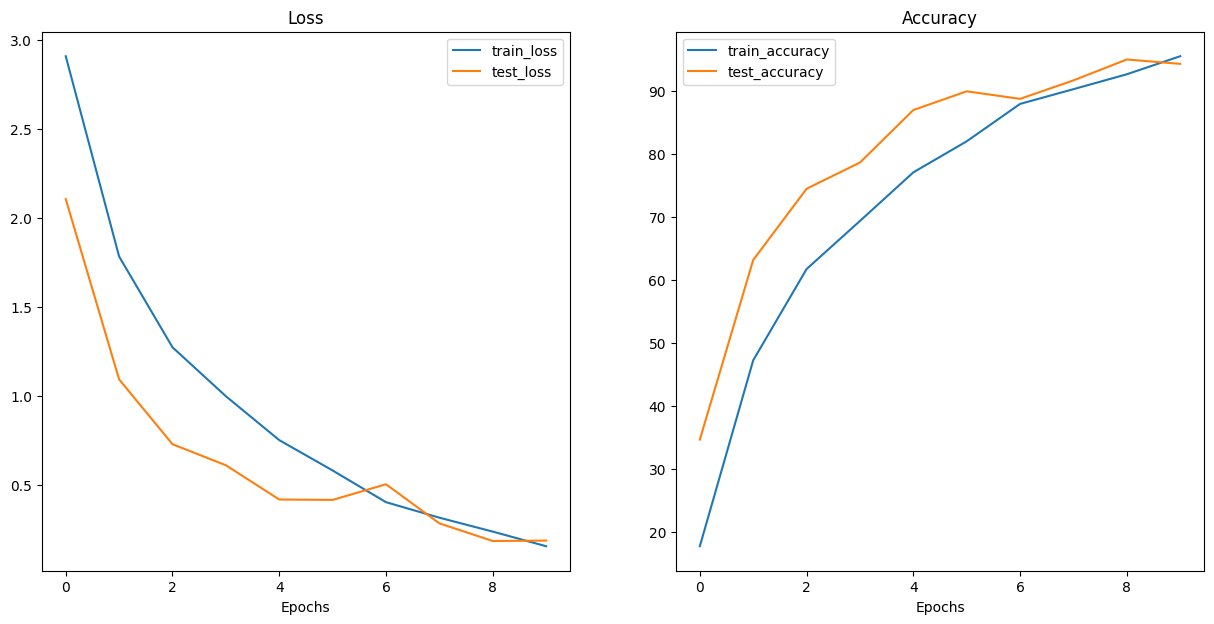

In [61]:
plot_loss_curves(results)

In [62]:
# prompt: write a function where I test a model using test_dataloader

def test_model(model, test_dataloader, loss_fn, device):
    """Tests the given model using the provided test dataloader.

    Args:
        model: The PyTorch model to test.
        test_dataloader: The DataLoader for the test dataset.
        loss_fn: The loss function to use for evaluation.
        device: The device (CPU or GPU) to run the evaluation on.

    Returns:
        A tuple containing the average test loss and the test accuracy.
    """

    model.eval()  # Set the model to evaluation mode
    test_loss, test_acc = 0, 0

    with torch.no_grad():  # Disable gradient calculations during testing
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            # Make predictions
            y_pred = model(X)

            # Calculate the loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            # Calculate the accuracy
            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    return test_loss / len(test_dataloader), test_acc / len(test_dataloader)

# Example usage:
test_loss, test_accuracy = test_model(model, test_dataloader, loss_fn, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.2258
Test Accuracy: 93.3642


In [63]:
# prompt: save the model and results of the training

# Save the model's state dictionary
torch.save(model.state_dict(), 'cards_classification_model.pth')

# Save the training results
import json
with open('training_results.json', 'w') as f:
    json.dump(results, f)

# Download the model and results files
files.download('cards_classification_model.pth')
files.download('training_results.json')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>